In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

In [13]:
def filter_white_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([255, 40, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    lower_yellow = np.array([18, 94, 140])
    upper_yellow = np.array([48, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    combined_mask = cv2.bitwise_or(white_mask, yellow_mask)
    filtered_image = cv2.bitwise_and(image, image, mask=combined_mask)
    return filtered_image

In [14]:
def dynamic_roi(image):
    height, width = image.shape
    bottom_left = [width * 0.1, height]
    top_left = [width * 0.4, height * 0.6]
    bottom_right = [width * 0.9, height]
    top_right = [width * 0.6, height * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return vertices

In [15]:
def roi(image, vertices):
    mask = np.zeros_like(image)
    mask_color = 255
    cv2.fillPoly(mask, vertices, mask_color)
    masked_img = cv2.bitwise_and(image, mask)
    return masked_img

In [16]:
def average_slope_intercept(image, lines):
    left_lines = []
    right_lines = []
    left_weights = []
    right_weights = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            length = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append(length)
            else:
                right_lines.append((slope, intercept))
                right_weights.append(length)

    left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if left_weights else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if right_weights else None
    return left_lane, right_lane

In [17]:
def make_line_points(y1, y2, line):
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

In [18]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(image, lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    return left_line, right_line

In [19]:

def draw_lane_lines(image, lines, color=[0, 255, 0], thickness=2):
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line, color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)

In [20]:
def perspective_transform(image):
    height, width = image.shape[:2]
    src = np.float32([[width, height-10],
                      [0, height-10],
                      [546, 460],
                      [732, 460]])
    dst = np.float32([[width, height],
                      [0, height],
                      [0, 0],
                      [width, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (width, height))
    return warped

In [21]:
def estimate_lane_width(lines):
    if lines is not None:
        line1 = lines[0][0]
        line2 = lines[1][0]
        lane_width_in_pixels = np.sqrt((line2[0] - line1[0])**2 + (line2[1] - line1[1])**2)
        return lane_width_in_pixels
    return None

Image Lane detection

Lane Width: 179.836036433191 pixels


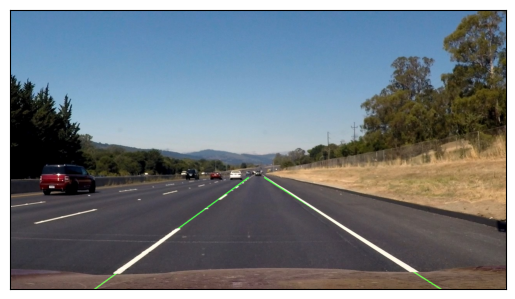

In [22]:
# Image data

img = cv2.imread("/content/Lane_image_dataset.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
filtered_img = filter_white_yellow(img)

# Convert to Grayscale
gray_img = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2GRAY)
gray_img = cv2.dilate(gray_img, kernel=np.ones((5, 5), np.uint8))

# Adaptive Canny Edge Detection
sigma = 0.33
v = np.median(gray_img)
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
canny = cv2.Canny(gray_img, lower, upper)

roi_vertices = dynamic_roi(canny)

# Apply ROI Mask

roi_image = roi(canny, roi_vertices)

# Apply Hough Lines P Method
lines = cv2.HoughLinesP(roi_image, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

left_line, right_line = lane_lines(img, lines)
final_img = draw_lane_lines(img, [left_line, right_line])
cv2.imwrite('/content/Lane_Detection_output.png', final_img)
# Perspective Transform (Bird's Eye View)

transformed_img = perspective_transform(img)

# Lane Width Estimation

lane_width = estimate_lane_width(lines)
print(f"Lane Width: {lane_width} pixels")

# Display the final image
plt.imshow(final_img)
plt.xticks([])
plt.yticks([])
plt.show()

Video Road lane detection

In [23]:

def calculate_lane_deviation(left_line, right_line, frame_width):
    lane_center = (left_line[0][0] + right_line[0][0]) / 2
    vehicle_center = frame_width / 2

    deviation = lane_center - vehicle_center
    return deviation

In [24]:
def roi(image, vertices):
    mask = np.zeros_like(image)
    mask_color = 255
    cv2.fillPoly(mask, vertices, mask_color)
    cropped_img = cv2.bitwise_and(image, mask)
    return cropped_img

In [25]:
def draw_lines(image, hough_lines):
    if hough_lines is not None:
        for line in hough_lines:
            if len(line[0]) == 4:
                x1, y1, x2, y2 = line[0]
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image

In [26]:
def process_frame(frame):
    height, width, _ = frame.shape
    roi_vertices = [
        (0, 650),
        (2*width/3, 2*height/3),
        (width, 1000)
    ]

    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.dilate(gray_img, kernel=np.ones((3, 3), np.uint8))

    _, white_mask = cv2.threshold(gray_img, 200, 255, cv2.THRESH_BINARY)

    roi_img = roi(white_mask, np.array([roi_vertices], np.int32))

    lines = cv2.HoughLinesP(roi_img, 1, np.pi / 180, threshold=10, minLineLength=15, maxLineGap=2)

    filtered_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs((y2 - y1) / (x2 - x1)) > 0.1:
            filtered_lines.append(line)

    final_img = draw_lines(frame, filtered_lines)

    return final_img

In [27]:
# Lane dataset
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture("/content/lane_dataset.mp4")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"XVID")
saved_frame = cv2.VideoWriter("lane_detection_output.avi", fourcc, 30.0, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        try:
            frame = process_frame(frame)

            saved_frame.write(frame)

            if cv2.waitKey(1) & 0xFF == 27:
                break

        except Exception as e:
            print("Error processing frame:", e)
            break
    else:
        break

cap.release()
saved_frame.release()
cv2.destroyAllWindows()

<ipython-input-26-64313ed22d1a>:21: RuntimeWarning: divide by zero encountered in scalar divide
  if abs((y2 - y1) / (x2 - x1)) > 0.1:


In [28]:
def process_frame2(frame):
    height, width, _ = frame.shape
    roi_vertices = [
        (0, 650),
        (2*width/3, 2*height/3),
        (width, 1000)
    ]

    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.dilate(gray_img, kernel=np.ones((3, 3), np.uint8))

    _, white_mask = cv2.threshold(gray_img, 200, 255, cv2.THRESH_BINARY)

    roi_img = roi(white_mask, np.array([roi_vertices], np.int32))

    lines = cv2.HoughLinesP(roi_img, 1, np.pi / 180, threshold=10, minLineLength=15, maxLineGap=2)

    filtered_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs((y2 - y1) / (x2 - x1)) > 0.5:
            filtered_lines.append(line)

    final_img = draw_lines(frame, filtered_lines)

    return final_img

In [29]:
# Street dataset
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture("/content/Street_dataset.mp4")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*"XVID")
saved_frame = cv2.VideoWriter("Street_lane_detection_output.avi", fourcc, 30.0, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        try:
            frame = process_frame2(frame)

            saved_frame.write(frame)

            if cv2.waitKey(1) & 0xFF == 27:
                break

        except Exception as e:
            print("Error processing frame:", e)
            break
    else:
        break

cap.release()
saved_frame.release()
cv2.destroyAllWindows()

<ipython-input-28-5500172ad343>:21: RuntimeWarning: divide by zero encountered in scalar divide
  if abs((y2 - y1) / (x2 - x1)) > 0.5:
